<a href="https://colab.research.google.com/github/soline013/Machine-Learning-ML/blob/master/Reinforcement-Learning/Reinforcement_Q_Learning_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Q Learning Cartpole

## Import

In [1]:
!apt-get install -y xvfb ffmpeg
!pip install -q 'imageio==2.4.0'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 1s (1,251 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 3.3MB 18.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is i

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameter

In [3]:
env_name = "CartPole-v0"
num_iterations = 250
collect_episodes_per_iteration = 2
replay_buffer_capacity = 2000

fc_layer_params = (100,)

learning_rate = 1e-3
log_interval = 25
num_eval_episodes = 10
eval_interval = 50

## Environment

In [4]:
env = suite_gym.load(env_name)

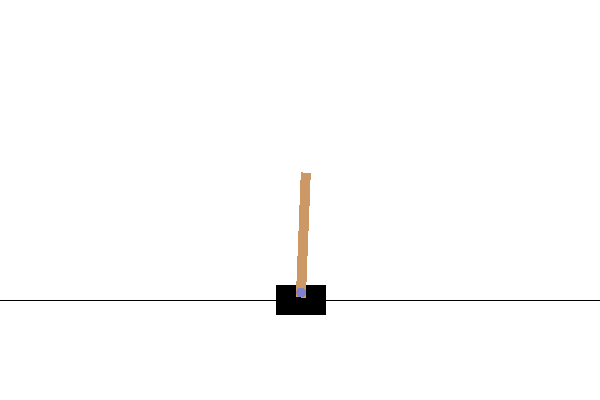

In [5]:
env.reset()
PIL.Image.fromarray(env.render())

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [7]:
time_step = env.reset()
print('Time Step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next Time Step:')
print(next_time_step)

Time Step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.00421494,  0.01947744,  0.0211268 , -0.03157749], dtype=float32))
Next Time Step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.00382539,  0.21429016,  0.02049525, -0.31752053], dtype=float32))


In [8]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agents

In [9]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [10]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

## Policy

In [11]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

## Metrics and Evaluation

In [12]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

## Replay Buffer

In [13]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

## Data Collection

In [14]:
def collect_episode(environment, policy, num_episodes):
  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1

## Training the agent

In [15]:
try:
  %%time
except:
  pass

tf_agent.train = common.function(tf_agent.train)

tf_agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
step = 25: loss = 0.0327795147895813
step = 50: loss = -0.5630025863647461
step = 50: Average Return = 87.19999694824219
step = 75: loss = -0.14154386520385742
step = 100: loss = -1.187225103378296
step = 100: Average Return = 136.3000030517578
step = 125: loss = -1.8395977020263672
step = 150: loss = -2.0010123252868652
step = 150: Average Return = 186.10000610351562
step = 175: loss = -2.163961410522461
step = 200: loss = 1.0569305419921875
step = 200: Average Return = 200.0
step = 225: loss = 0.8586630821228027
step = 250: loss = 0.6223278045654297
step = 250: Average Return = 200.0


## Visualization

(-0.44499959945678746, 250.0)

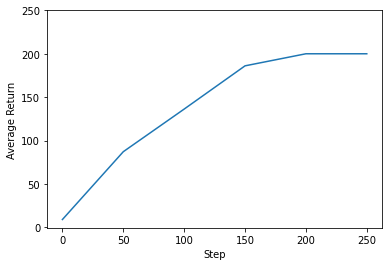

In [16]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [17]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [18]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)